## 3D segmentation of BraTS2020 dataset

#### Setup the custom datagenerator

In [1]:
import os
import random
import glob
import numpy as np
import custom_datagenerator as datagen
import matplotlib.pyplot as plt

In [2]:
# define our data paths
train_img_path = "data_dir/train_and_val/train/images"
train_mask_path = "data_dir/train_and_val/train/masks"

val_img_path = "data_dir/train_and_val/val/images"
val_mask_path = "data_dir/train_and_val/val/masks"

print(train_img_path)
print(train_mask_path)
print(val_img_path)
print(val_mask_path)

data_dir/train_and_val/train/images
data_dir/train_and_val/train/masks
data_dir/train_and_val/val/images
data_dir/train_and_val/val/masks


In [3]:
# Get a list of the images and masks
train_img_list = sorted(os.listdir(train_img_path))
train_mask_list = sorted(os.listdir(train_mask_path))

val_img_list = sorted(os.listdir(val_img_path))
val_mask_list = sorted(os.listdir(val_mask_path))

In [4]:
# Check if the sorting made them match up
print(train_img_list[0:5])
print(train_mask_list[0:5])

num_images = len(os.listdir(train_img_path))
print(f"\nNumber of training images: {num_images}")

['image_0.npy', 'image_1.npy', 'image_10.npy', 'image_101.npy', 'image_102.npy']
['mask_0.npy', 'mask_1.npy', 'mask_10.npy', 'mask_101.npy', 'mask_102.npy']

Number of training images: 258


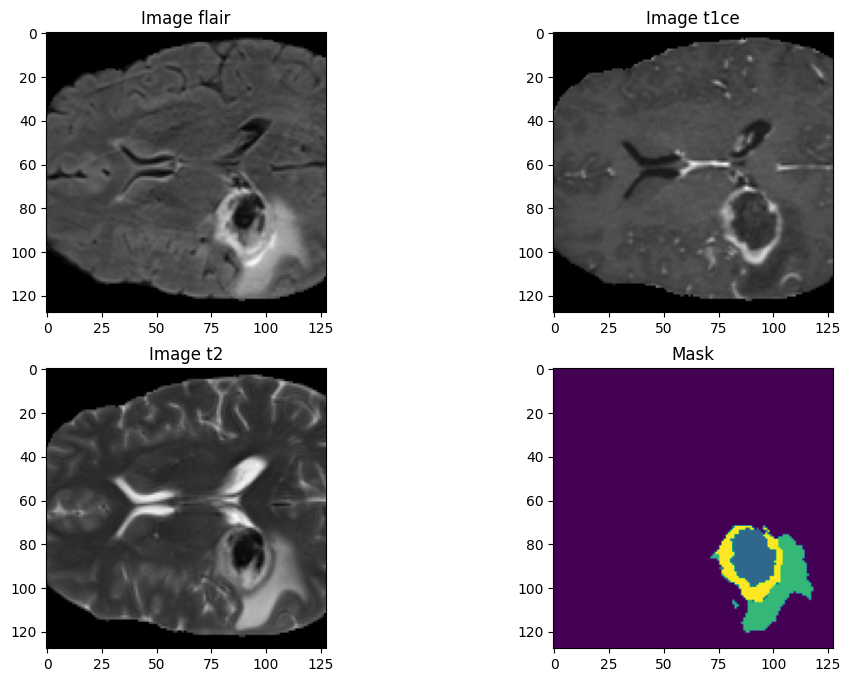

In [5]:
# A last check if the images makes sense
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_path + "/" + train_img_list[img_num])
test_mask = np.load(train_mask_path + "/" +train_mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [10]:
### Compute the weights
import warnings
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list_temp = sorted(glob.glob('data_dir/train_and_val/train/masks/*.npy'))
for img in range(len(train_mask_list_temp)):
    #print(img)
    temp_image=np.load(train_mask_list_temp[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(f"Weight of label 0: {wt0}")
print(f"Weight of label 1: {wt1}")
print(f"Weight of label 2: {wt2}")
print(f"Weight of label 3: {wt3}")

#These weights can be used for Dice loss 

Weight of label 0: 0.26
Weight of label 0: 22.53
Weight of label 0: 22.53
Weight of label 0: 26.21


In [7]:
wt0 = 0.26;wt1=22.53;wt2=22.53;wt3=26.21

In [8]:
# Make the generator avaiable
batch_size = 1

train_img_datagen = datagen.imageLoader(train_img_path, train_img_list, train_mask_path, train_mask_list,
                                       batch_size)

val_img_datagen = datagen.imageLoader(val_img_path, val_img_list, val_mask_path, val_mask_list,
                                       batch_size)

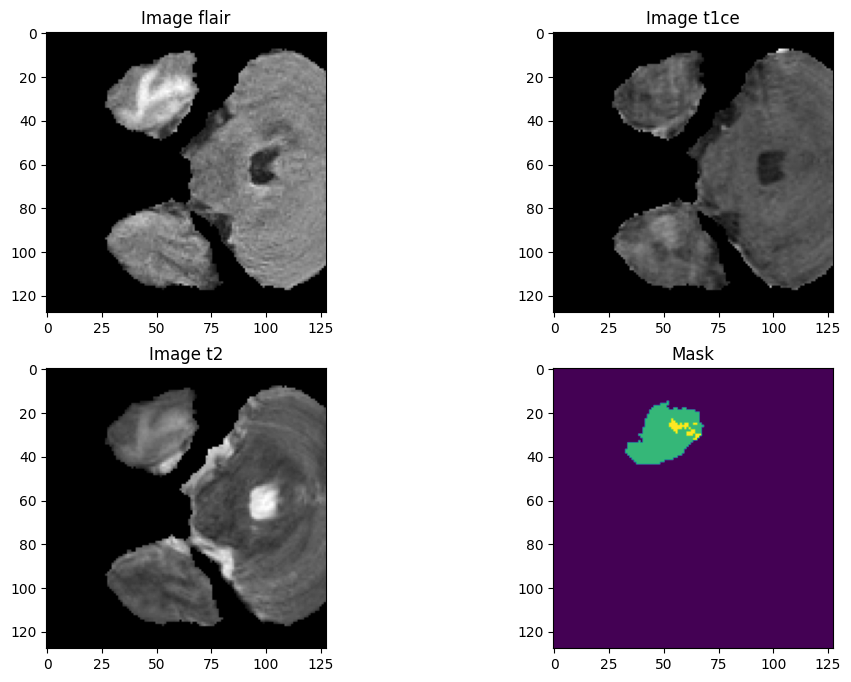

In [9]:
# Check that the generator works properly
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

### Modelling

In [10]:
import tensorflow as tf
import segmentation_models_3D as sm
#os.environ["KERAS_BACKEND"] = "tensorflow"

Segmentation Models: using `tf.keras` framework.


In [11]:
dice_loss = sm.losses.DiceLoss(class_weights = np.array([wt0,wt1,wt2,wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [12]:
metrics = ["accuracy", sm.metrics.IOUScore(threshold = 0.5)]
lr = 0.0001
optim = tf.keras.optimizers.Adam(lr)

In [13]:
train_steps = len(train_img_list) // batch_size
val_steps = len(val_img_list) // batch_size

##### Basic 3D Unet

In [54]:
from unet_basic import simple_unet_model
model = simple_unet_model(IMG_HEIGHT = 128,
                          IMG_WIDTH = 128,
                          IMG_DEPTH = 128,
                          IMG_CHANNELS = 3,
                          num_classes = 4)

In [55]:
model.compile(optimizer = optim, loss = total_loss, metrics = metrics)

In [56]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [57]:
history = model.fit(train_img_datagen,
                   steps_per_epoch = train_steps,
                   validation_data = val_img_datagen,
                   validation_steps = val_steps,
                   epochs = 100, verbose = 1)

Epoch 1/100
258/258 [==============================] - 118s 429ms/step - loss: -0.6001 - accuracy: 0.7201 - iou_score: 0.1918 - val_loss: -2.0251 - val_accuracy: 0.9216 - val_iou_score: 0.3151
Epoch 2/100
258/258 [==============================] - 109s 422ms/step - loss: -2.2809 - accuracy: 0.8995 - iou_score: 0.3147 - val_loss: -2.8561 - val_accuracy: 0.9155 - val_iou_score: 0.3327
Epoch 3/100
258/258 [==============================] - 110s 425ms/step - loss: -2.8875 - accuracy: 0.9206 - iou_score: 0.3400 - val_loss: -3.6000 - val_accuracy: 0.9442 - val_iou_score: 0.3637
Epoch 4/100
258/258 [==============================] - 108s 418ms/step - loss: -4.1682 - accuracy: 0.9456 - iou_score: 0.3842 - val_loss: -4.6440 - val_accuracy: 0.9545 - val_iou_score: 0.3996
Epoch 5/100
258/258 [==============================] - 107s 416ms/step - loss: -5.0768 - accuracy: 0.9560 - iou_score: 0.4163 - val_loss: -5.2223 - val_accuracy: 0.9580 - val_iou_score: 0.4222
Epoch 6/100
258/258 [==============

258/258 [==============================] - 109s 421ms/step - loss: -12.3999 - accuracy: 0.9864 - iou_score: 0.7211 - val_loss: -10.7991 - val_accuracy: 0.9807 - val_iou_score: 0.6518
Epoch 44/100
258/258 [==============================] - 110s 426ms/step - loss: -12.3953 - accuracy: 0.9862 - iou_score: 0.7208 - val_loss: -10.6699 - val_accuracy: 0.9805 - val_iou_score: 0.6460
Epoch 45/100
258/258 [==============================] - 110s 425ms/step - loss: -12.4546 - accuracy: 0.9866 - iou_score: 0.7241 - val_loss: -10.7612 - val_accuracy: 0.9809 - val_iou_score: 0.6507
Epoch 46/100
258/258 [==============================] - 110s 427ms/step - loss: -12.4492 - accuracy: 0.9865 - iou_score: 0.7235 - val_loss: -10.7729 - val_accuracy: 0.9798 - val_iou_score: 0.6501
Epoch 47/100
258/258 [==============================] - 109s 424ms/step - loss: -12.4717 - accuracy: 0.9866 - iou_score: 0.7240 - val_loss: -10.8605 - val_accuracy: 0.9804 - val_iou_score: 0.6550
Epoch 48/100
258/258 [===========

Epoch 85/100
258/258 [==============================] - 108s 419ms/step - loss: -13.4164 - accuracy: 0.9900 - iou_score: 0.7750 - val_loss: -11.2056 - val_accuracy: 0.9820 - val_iou_score: 0.6689
Epoch 86/100
258/258 [==============================] - 108s 418ms/step - loss: -13.4428 - accuracy: 0.9900 - iou_score: 0.7772 - val_loss: -11.0679 - val_accuracy: 0.9797 - val_iou_score: 0.6626
Epoch 87/100
258/258 [==============================] - 107s 416ms/step - loss: -13.3776 - accuracy: 0.9899 - iou_score: 0.7739 - val_loss: -11.0409 - val_accuracy: 0.9802 - val_iou_score: 0.6608
Epoch 88/100
258/258 [==============================] - 109s 422ms/step - loss: -13.3158 - accuracy: 0.9896 - iou_score: 0.7707 - val_loss: -11.0630 - val_accuracy: 0.9808 - val_iou_score: 0.6630
Epoch 89/100
258/258 [==============================] - 107s 416ms/step - loss: -13.3475 - accuracy: 0.9896 - iou_score: 0.7734 - val_loss: -11.1779 - val_accuracy: 0.9816 - val_iou_score: 0.6682
Epoch 90/100
258/258

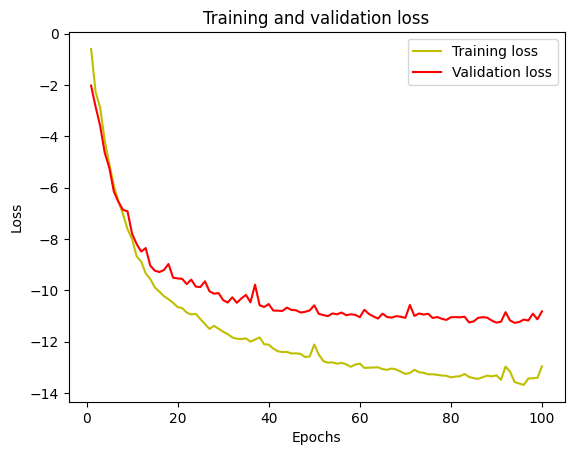

In [58]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

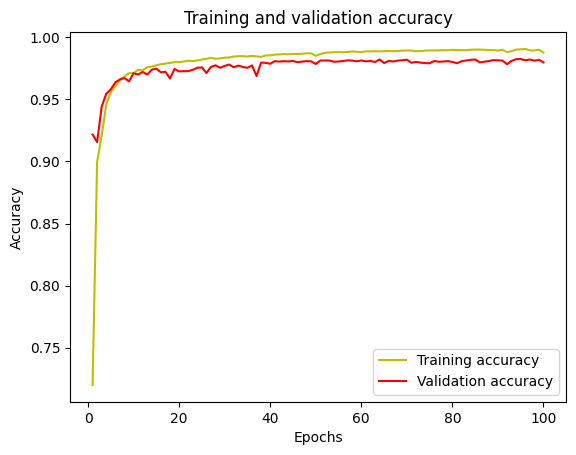

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
# Make a folder to store models
os.mkdir("models")
# Save the current model
model.save("models/brats_3dV1.hdf5")

##### 3D Unet with attention



In [14]:
# Define the hyperparameters
metrics = ["accuracy", sm.metrics.IOUScore(threshold = 0.5)]
lr = 0.0001
optim = tf.keras.optimizers.Adam(lr)
train_steps = len(train_img_list) // batch_size
val_steps = len(val_img_list) // batch_size
batch_size = 1

In [15]:
from unet_attent import attention_unet_model
model_att = attention_unet_model(IMG_HEIGHT = 128,
                          IMG_WIDTH = 128,
                          IMG_DEPTH = 128,
                          IMG_CHANNELS = 3,
                          num_classes = 4)

In [16]:
model_att.compile(optimizer = optim, loss = total_loss, metrics = metrics)

In [17]:
history_att = model_att.fit(train_img_datagen,
                   steps_per_epoch = train_steps,
                   validation_data = val_img_datagen,
                   validation_steps = val_steps,
                   epochs = 100, verbose = 1)

Epoch 1/100
258/258 [==============================] - 140s 503ms/step - loss: -2.0029 - accuracy: 0.8662 - iou_score: 0.3001 - val_loss: 0.6405 - val_accuracy: 0.9516 - val_iou_score: 0.2647
Epoch 2/100
258/258 [==============================] - 125s 484ms/step - loss: -5.7978 - accuracy: 0.9593 - iou_score: 0.4425 - val_loss: -3.7493 - val_accuracy: 0.9589 - val_iou_score: 0.3891
Epoch 3/100
258/258 [==============================] - 126s 487ms/step - loss: -6.8422 - accuracy: 0.9666 - iou_score: 0.4805 - val_loss: 0.1108 - val_accuracy: 0.9537 - val_iou_score: 0.2803
Epoch 4/100
258/258 [==============================] - 126s 490ms/step - loss: -7.0956 - accuracy: 0.9675 - iou_score: 0.4914 - val_loss: -3.5315 - val_accuracy: 0.9612 - val_iou_score: 0.3835
Epoch 5/100
258/258 [==============================] - 126s 487ms/step - loss: -7.3918 - accuracy: 0.9691 - iou_score: 0.4998 - val_loss: -0.0905 - val_accuracy: 0.9540 - val_iou_score: 0.2851
Epoch 6/100
258/258 [================

258/258 [==============================] - 121s 468ms/step - loss: -12.6417 - accuracy: 0.9867 - iou_score: 0.7310 - val_loss: -10.7500 - val_accuracy: 0.9784 - val_iou_score: 0.6476
Epoch 86/100
258/258 [==============================] - 122s 474ms/step - loss: -12.3368 - accuracy: 0.9853 - iou_score: 0.7161 - val_loss: -10.6035 - val_accuracy: 0.9744 - val_iou_score: 0.6390
Epoch 87/100
258/258 [==============================] - 124s 482ms/step - loss: -12.5196 - accuracy: 0.9861 - iou_score: 0.7260 - val_loss: -10.7676 - val_accuracy: 0.9795 - val_iou_score: 0.6521
Epoch 88/100
258/258 [==============================] - 124s 479ms/step - loss: -11.9628 - accuracy: 0.9843 - iou_score: 0.7027 - val_loss: -9.5929 - val_accuracy: 0.9559 - val_iou_score: 0.5926
Epoch 89/100
258/258 [==============================] - 123s 479ms/step - loss: -12.1155 - accuracy: 0.9847 - iou_score: 0.7050 - val_loss: -10.9166 - val_accuracy: 0.9789 - val_iou_score: 0.6562
Epoch 90/100
258/258 [============

In [19]:
model_att.save("models/brats_3dAttention.hdf5")

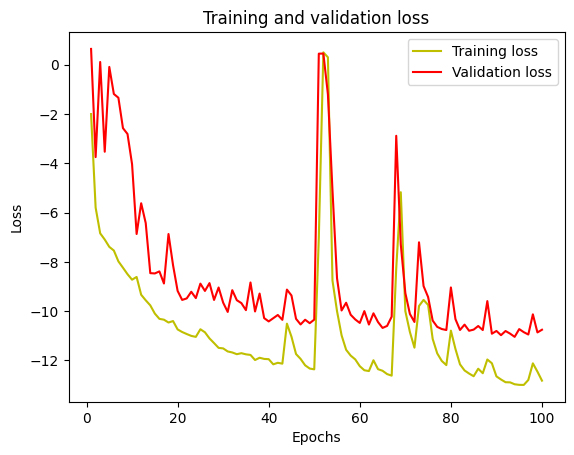

In [22]:
#plot the training and validation IoU and loss at each epoch
loss = history_att.history['loss']
val_loss = history_att.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

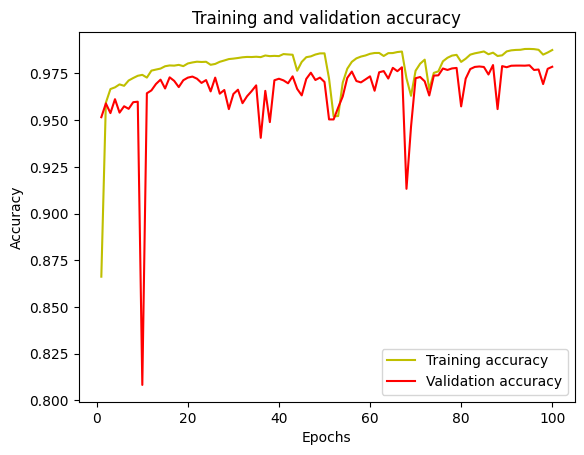

In [23]:
acc = history_att.history['accuracy']
val_acc = history_att.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()